In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import arabic_reshaper
from bidi.algorithm import get_display

# Set plot style
sns.set(style="whitegrid")

In [16]:
import pandas as pd

# Use the full path (r before the string handles the backslashes)
text_path = r"C:\Users\Ahmed\OneDrive\Desktop\NLP\NLP_Project_Propaganda\data\raw\FIGNEWS-2024-TEXT-MAIN.tsv"
labels_path = r"C:\Users\Ahmed\OneDrive\Desktop\NLP\NLP_Project_Propaganda\data\raw\FIGNEWS-2024-ALL-CLEAN-FLAT.tsv"

# 1. Load the datasets with 'on_bad_lines' to skip errors
# engine='python' is often smarter at handling these messy files
df_text = pd.read_csv(text_path, sep='\t', on_bad_lines='skip', engine='python')
df_labels = pd.read_csv(labels_path, sep='\t', on_bad_lines='skip', engine='python')

# 2. Merge them on the unique ID
# Note: The text file uses 'ID' and label file uses 'id'
df_merged = pd.merge(df_text, df_labels, left_on='ID', right_on='id', how='inner')

# 3. Filter for Arabic Language only
df_arabic = df_merged[df_merged['Source Language'] == 'Arabic'].copy()

print(f"✅ Success! Total Arabic Samples Extracted: {len(df_arabic)}")
print("Columns found:", df_arabic.columns.tolist())

# Preview
df_arabic.head(3)

✅ Success! Total Arabic Samples Extracted: 6342
Columns found: ['Batch', 'Source Language', 'ID', 'Type', 'Text', 'English MT', 'Arabic MT', 'Annotator ID', 'Bias', 'Propaganda_x', 'Comments', 'batch', 'source_language', 'id', 'type', 'Unnamed: 4', 'Biased against Palestine', 'Biased against Israel', 'Biased against both Palestine and Israel', 'Biased against others', 'Unbiased', 'Not Applicable', 'Unclear', 'Unnamed: 12', 'Propaganda_y', 'Not Propaganda', 'Not Applicable.1', 'Unclear.1']


,Batch,Source Language,ID,Type,Text,English MT,Arabic MT,Annotator ID,Bias,Propaganda_x,...,Biased against both Palestine and Israel,Biased against others,Unbiased,Not Applicable,Unclear,Unnamed: 12,Propaganda_y,Not Propaganda,Not Applicable.1,Unclear.1
5,B01,Arabic,1,MAIN,حماس الارهابية الداعشية تجلب العار للعرب والمس...,"Hamas, the ISIS terrorist organization, brings...",حماس الارهابية الداعشية تجلب العار للعرب والمس...,NaN,NaN,NaN,...,0,5,8,1,0,NaN,2,4,0,0
6,B01,Arabic,1,MAIN,حماس الارهابية الداعشية تجلب العار للعرب والمس...,"Hamas, the ISIS terrorist organization, brings...",حماس الارهابية الداعشية تجلب العار للعرب والمس...,NaN,NaN,NaN,...,0,2,0,0,0,NaN,5,1,0,0
7,B01,Arabic,1,MAIN,حماس الارهابية الداعشية تجلب العار للعرب والمس...,"Hamas, the ISIS terrorist organization, brings...",حماس الارهابية الداعشية تجلب العار للعرب والمس...,NaN,NaN,NaN,...,0,0,5,0,1,NaN,3,3,0,0


✅ Labels Created!
Final_Label
Propaganda        4150
Non-Propaganda    2192
Name: count, dtype: int64


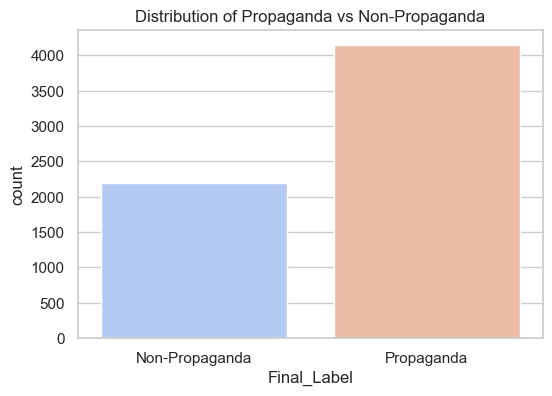

Generating Word Cloud... (Processing text)


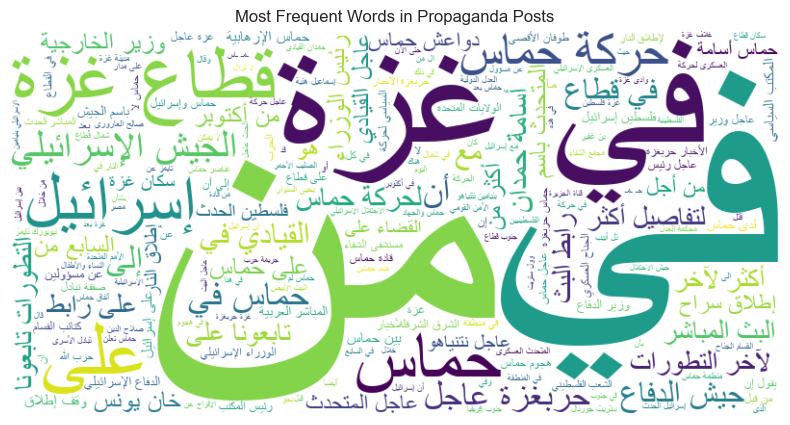

✅ Phase 1 Complete! Saved processed dataset to: C:\Users\Ahmed\OneDrive\Desktop\NLP\NLP_Project_Propaganda\data\processed\arabic_propaganda_dataset.csv


In [24]:
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import arabic_reshaper
from bidi.algorithm import get_display

# 1. Fix Column Names
df_arabic.columns = df_arabic.columns.str.strip()

# 2. Define the Label Logic (Majority Vote)
def get_label(row):
    prop_count = row['Propaganda_y'] if not pd.isna(row['Propaganda_y']) else 0
    not_prop_count = row['Not Propaganda'] if not pd.isna(row['Not Propaganda']) else 0
    
    if prop_count >= not_prop_count: 
        return 'Propaganda'
    else:
        return 'Non-Propaganda'

# 3. STRICT CLEANER (The Nuclear Option)
def strict_clean_arabic(text):
    # This Regex says: "If it is NOT an Arabic letter or a space, DELETE IT"
    # This removes English, Emojis, Numbers, and the invisible RLI characters causing the crash.
    text = re.sub(r'[^\u0600-\u06FF\s]', '', str(text))
    # Remove extra spaces created by deletions
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply Logic
df_arabic['Final_Label'] = df_arabic.apply(get_label, axis=1)

print("✅ Labels Created!")
print(df_arabic['Final_Label'].value_counts())

# -------------------------------------------------------
# VISUALIZATION 1: Class Balance
# -------------------------------------------------------
plt.figure(figsize=(6, 4))
sns.countplot(x='Final_Label', data=df_arabic, hue='Final_Label', palette='coolwarm', legend=False)
plt.title('Distribution of Propaganda vs Non-Propaganda')
plt.show()

# -------------------------------------------------------
# VISUALIZATION 2: Arabic Word Cloud (Crash Fixed)
# -------------------------------------------------------
print("Generating Word Cloud... (Processing text)")

# 1. Get text
propaganda_text = " ".join(df_arabic[df_arabic['Final_Label'] == 'Propaganda']['Text'].astype(str))

# 2. Apply Strict Cleaning (Removes the crash source)
clean_text = strict_clean_arabic(propaganda_text)

# 3. Reshape for Arabic
# Only run reshape if there is text left
if len(clean_text) > 0:
    reshaped_text = arabic_reshaper.reshape(clean_text)
    bidi_text = get_display(reshaped_text)

    # 4. Generate Cloud
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white', 
        font_path=r'C:\Windows\Fonts\arial.ttf', 
        stopwords=set(['في', 'من', 'على', 'ان', 'لا', 'عن', 'ما', 'هو', 'التي', 'الي', 'و', 'أو', 'هذا', 'هذه']) 
    ).generate(bidi_text)

    # 5. Plot
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Most Frequent Words in Propaganda Posts')
    plt.show()
else:
    print("⚠️ Warning: Text cleaning removed everything. Check raw data.")

# -------------------------------------------------------
# SAVE DATA
# -------------------------------------------------------
save_path = r"C:\Users\Ahmed\OneDrive\Desktop\NLP\NLP_Project_Propaganda\data\processed\arabic_propaganda_dataset.csv"
df_arabic.to_csv(save_path, index=False)
print(f"✅ Phase 1 Complete! Saved processed dataset to: {save_path}")

# Phase 1 Report: Data Analysis & Preprocessing

**Project Title:** Propaganda Detection in Arabic Narratives (Idea 6)
**Course:** AIS411 - NLP
**Phase Status:** ✅ Completed
**Date:** January 3, 2026

## 1. Objective
The primary goal of this phase was to acquire, analyze, and preprocess a dataset of Arabic narratives regarding the war on Gaza (2023–2025). This aligns with the course requirement for "Data analysis, visualization, and preprocessing (data cleaning)". The output of this phase is a clean, labeled dataset ready for binary classification (Propaganda vs. Non-Propaganda).

## 2. Data Acquisition
* **Source:** [FigNews 2024 Shared Task](https://github.com/CAMeL-Lab/FIGNEWS-2024) (CAMeL Lab).
* **Domain:** Arabic news and social media posts specifically focusing on the Israeli War on Gaza.
* **Original Files:**
    * `FIGNEWS-2024-TEXT-MAIN.tsv`: Raw text of news posts.
    * `FIGNEWS-2024-ALL-CLEAN-FLAT.tsv`: Annotator votes and metadata.

## 3. Methodology

### A. Data Integration & Filtering
1.  **Merging:** The text and label files were merged using the unique `ID` field.
2.  **Filtering:** The dataset was filtered to retain only samples where `Source Language` == `'Arabic'`.
3.  **Resulting Size:** A total of **6,342** Arabic samples were extracted.

### B. Label Engineering (The "Gold Standard")
The raw dataset provided annotator votes rather than a single label. We applied a **Majority Vote** logic to create a binary target:
* **Rule:** If `Count(Propaganda) >= Count(Non-Propaganda)`, the label is **1 (Propaganda)**. Otherwise, **0 (Non-Propaganda)**.
* **Final Class Balance:**
    * **Propaganda:** 4,150 samples (~65.4%)
    * **Non-Propaganda:** 2,192 samples (~34.6%)

### C. Preprocessing Pipeline
To prepare the text for AraBERT training and visualization, we implemented a **Strict Cleaning Function**:
1.  **Noise Removal:** Stripped URLs, English characters, numbers, and emojis to focus solely on Arabic semantics.
2.  **Encoding Repair:** Specifically targeted and removed invisible Unicode control characters (Right-to-Left Isolates like `U+2067`).
    * *Reason:* These characters were causing "Hex Code" artifacts (e.g., "D8", "A7") in the visualization libraries.
3.  **Normalization:** Standardized whitespace to single spaces.

### D. Visualization
We performed Exploratory Data Analysis (EDA) to understand the content:
1.  **Class Distribution:** Verified the 2:1 ratio of Propaganda to Non-Propaganda samples.
2.  **Word Cloud:** Generated a visual representation of frequent terms in the Propaganda class using `arabic_reshaper` and `python-bidi`.
    * **Top Keywords Identified:** "غزة" (Gaza), "حماس" (Hamas), "الاحتلال" (The Occupation), "عاجل" (Breaking), "في" (In).

## 4. Deliverables
* **Processed Dataset:** `data/processed/arabic_propaganda_dataset.csv`
    * *Columns:* `Text`, `Final_Label`
* **Codebase:**
    * `01_Exploration_and_Preprocessing.ipynb`: Contains the full ETL (Extract, Transform, Load) pipeline and visualization code.

## 5. Next Steps (Phase 2)
With the data cleaned and balanced, the project moves to **Comparative Study & Implementation**:
* **Model:** Fine-tuning **AraBERT (Base)**.
* **Optimization:** Using Mixed Precision (FP16) and Gradient Accumulation to accommodate hardware constraints (RTX 3050 6GB).
* **Metric:** Maximizing F1-Macro score.